# Simple search engine over the wikidataset

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import urllib.request
import json

In [3]:
from wikisearch.retrieval import WikiDataset
import wikisearch.retrieval as rt

## Get the data

In [4]:
url = 'http://island.ricerca.di.unimi.it/~alfio/shared/inforet/wikipeople.json'
data = WikiDataset(url=url)

## Search Engine

In [5]:
V = rt.TfIdfVectors(data.documents, rt.NLTKTokenizer())
E = rt.SearchEngine(vectorizer=V)

In [6]:
answers, scores = E.search('napoleon french emperor triumph')

In [57]:
query = data.get_queries()[2]
entity = data.query_map[query]

In [58]:
query, entity

('Jesus preacher leader figure Christianity', 'Q302')

In [59]:
answers, scores = E.search(query)
y_true = data.validate_answers(entity, answers)

In [60]:
answers[:6], y_true[:6]

([92, 188, 194, 192, 126, 95], [1, 1, 1, 1, 1, 1])

In [61]:
y_true[:10], y_true[10:20]

([1, 1, 1, 1, 1, 1, 0, 1, 1, 1], [0, 0, 1, 1, 1, 0, 1, 1, 0, 0])

## Exercise 1: Evaluate search performances

In [62]:
def p_r(y_true, top_k):
    tp = sum(y_true[:top_k])
    fp = top_k - tp
    fn = sum(y_true[top_k:])
    return tp / (tp + fp), tp / (tp + fn)

In [63]:
p_r(y_true=y_true, top_k=190)

(0.6052631578947368, 0.9426229508196722)

In [64]:
dcg = lambda y_true: sum([x / np.log(i+2) for i, x in enumerate(y_true)])

In [65]:
dcg(y_true), sum(y_true), dcg([1]*sum(y_true)), dcg(y_true) / dcg([1]*sum(y_true))

(32.55673774087306, 122, 34.86846087224767, 0.9337016010014213)

In [66]:
from sklearn.metrics import precision_recall_curve

In [67]:
precision, recall, threshold = precision_recall_curve(y_true, scores)

In [68]:
import matplotlib.pyplot as plt

In [69]:
iprec = []
for i, w in enumerate(precision):
    iprec.append(max(precision[:i+1]))

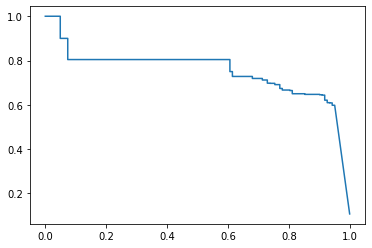

In [70]:
fig, ax = plt.subplots()
ax.plot(recall, iprec)
plt.show()

In [71]:
delta = np.diff(list(reversed(recall)))

In [72]:
(delta * (list(reversed(precision))[:-1])).sum()

0.7331173427080756

## Exercise 2: Compare search performances on different systems

In [50]:
import spacy

In [51]:
Vs = rt.TfIdfVectors(data.documents, rt.SpacyTokenizer())
Es = rt.SearchEngine(vectorizer=Vs)

In [52]:
answers_s, scores_s = Es.search(query)
y_true_s = data.validate_answers(entity, answers_s)

In [53]:
precision_s, recall_s, threshold_s = precision_recall_curve(y_true_s, scores_s)

In [54]:
iprec_s= []
for i, w in enumerate(precision_s):
    iprec_s.append(max(precision_s[:i+1]))

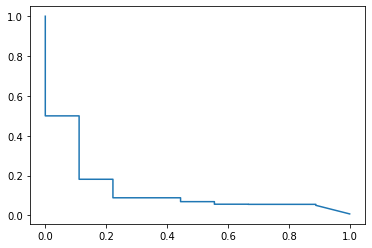

In [55]:
fig, ax = plt.subplots()
ax.plot(recall_s, iprec_s)
plt.show()

In [56]:
(np.diff(list(reversed(recall_s))) * (list(reversed(precision_s))[:-1])).sum()

0.051799806170688516

### Analyzing errors

In [73]:
gt = y_true[:100]
an = answers[:100]

In [76]:
tpcorpus, fpcorpus = [], []
for i, x in enumerate(gt):
    doc = data.documents[an[i]]
    if x == 1:
        tpcorpus.append(doc)
    else:
        fpcorpus.append(doc)

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

In [82]:
Ctp, Cfp = CountVectorizer(tokenizer=nltk.word_tokenize), CountVectorizer(tokenizer=nltk.word_tokenize)

In [84]:
Xtp = Ctp.fit_transform(tpcorpus)
Xfp = Cfp.fit_transform(fpcorpus)
A = CountVectorizer(tokenizer=nltk.word_tokenize).fit_transform(data.documents)

In [105]:
w = 'is'
Ctp.get_feature_names().index(w)

1284

In [106]:
n = sum(Xtp[:,Ctp.get_feature_names().index(w)].toarray())[0]
N = Xtp.toarray().sum()
z = sum(Xfp[:,Cfp.get_feature_names().index(w)].toarray())[0]
Z = Xfp.toarray().sum()

(n / N) * np.log((n / N) / (z / Z))

0.0009619800953829529

## Exercise 3: Improve search performances